In [116]:
import tensorflow as tf
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!wget -nc 'https://github.com/alexdlilly/DS6050_Project/raw/main/covid.tfrecords' 
!wget -nc 'https://github.com/alexdlilly/DS6050_Project/raw/main/healthy.tfrecords' 

File ‘covid.tfrecords’ already there; not retrieving.

File ‘healthy.tfrecords’ already there; not retrieving.



### Ingest the healthy records

In [98]:
####################################################################
# Adjust the file path to be where your tf records have downloaded!#
####################################################################
filenames = ['/scratch/kzr3fb/DS6050_Project/healthy.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [99]:
def _parse_function(example_proto):
    feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'covid': tf.io.FixedLenFeature([], tf.float32, default_value=0),
}
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_image(parsed['image_raw'])
    image = tf.reshape(image,[512,512,3])
    print(parsed['covid'])
    return image,parsed['covid']

In [100]:
healthy = raw_dataset.map(_parse_function)
healthy

Tensor("ParseSingleExample/ParseExample/ParseExampleV2:0", shape=(), dtype=float32)


<_MapDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

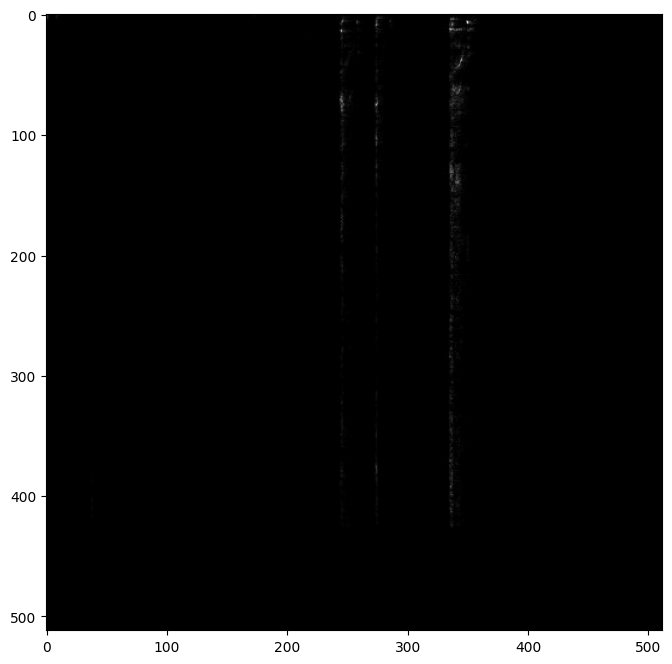

tf.Tensor(0.0, shape=(), dtype=float32)


In [101]:
for image_features in healthy.skip(100).take(1):
    image_raw = image_features[0]
    plt.figure(figsize=(8,8))
    plt.imshow(tf.transpose(image_raw)[0],cmap='gist_gray')
    plt.show()
    print(image_features[1])

### Ingest the covid records

In [102]:
####################################################################
# Adjust the file path to be where your tf records have downloaded!#
####################################################################
filenames = ['/scratch/kzr3fb/DS6050_Project/covid.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [103]:
covid = raw_dataset.map(_parse_function)

Tensor("ParseSingleExample/ParseExample/ParseExampleV2:0", shape=(), dtype=float32)


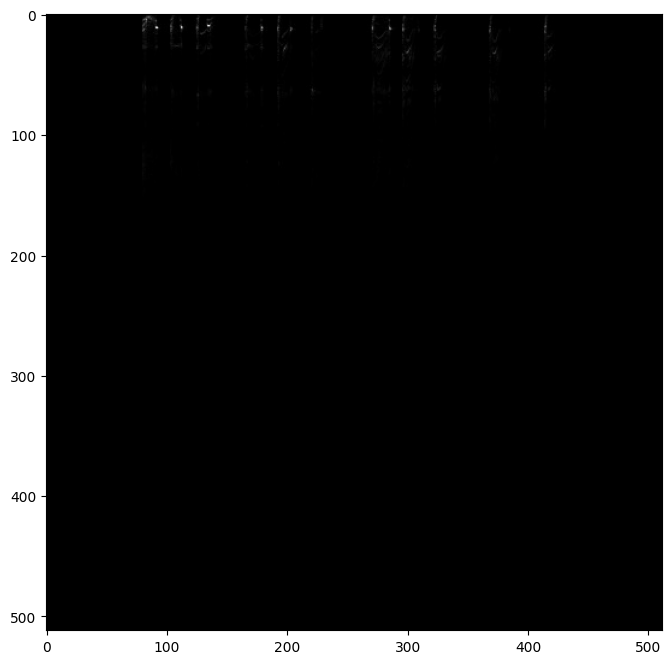

tf.Tensor(1.0, shape=(), dtype=float32)


In [104]:
for image_features in covid.skip(100).take(1):
    image_raw = image_features[0]
    plt.figure(figsize=(8,8))
    plt.imshow(tf.transpose(image_raw)[0],cmap='gist_gray')
    plt.show()
    print(image_features[1])

### Concatenate the healthy and covid records into one tensor

In [144]:
data = covid.concatenate(healthy)
length_dataset = data.reduce(0, lambda x,_: x+1).numpy()

In [145]:
length_dataset

12833

In [147]:
data = data.shuffle(buffer_size=10000).cache().batch(16).prefetch(8)

In [148]:
train = data.take(9000)
test = data.skip(9000).take(length_dataset-9000)
samples,labels=train.as_numpy_iterator().next()
samples.shape[1:4]

2023-10-26 00:59:42.426509: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(512, 512, 3)

### Define model architecture

In [149]:
inputs = keras.Input(shape=samples.shape[1:4])

base_model = keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    input_shape=samples.shape[1:4],
    pooling=None,
    classes=2,
    classifier_activation="sigmoid",
    include_preprocessing=True,
)

base_model.trainable = False

x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [150]:
model.compile('Adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [151]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, 16, 16, 1280)      20331360  
 al)                                                             
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 20332641 (77.56 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 20331360 (77.56 MB)
_________________________________________________________________


In [153]:
hist=model.fit(train,epochs=5,validation_data=test)

Epoch 1/5
803/803 [==============================] - 83s 87ms/step - loss: 0.2967 - accuracy: 0.0000e+00 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00
Epoch 2/5
  1/803 [..............................] - ETA: 1:11 - loss: 0.3742 - accuracy: 0.0000e+00 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00

2023-10-26 01:01:28.143891: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8275218288750914999
2023-10-26 01:01:28.144330: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6916693548678014573


803/803 [==============================] - 66s 82ms/step - loss: 0.2910 - accuracy: 0.0000e+00 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00
Epoch 3/5
803/803 [==============================] - 66s 82ms/step - loss: 0.2898 - accuracy: 0.0000e+00 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00
Epoch 4/5
440/803 [===============>..............] - ETA: 29s - loss: 0.2898 - accuracy: 0.0000e+00 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00

KeyboardInterrupt: 